In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
from torchvision.io import read_image
from skimage import io, transform
import torchsummary

import torch.nn as nn
import torch.nn.functional as F

class YourCustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, input, target, split, input_beta = 0.01, train_transform=None):
        """
        Args:
            root_path (str): path to data
            input (str): specific path to input data 
            target (str): specific path to target (annotation) data
            split (str): split to get data from ("train", "test", or "val")
            input_beta (float): defines the synthetic fog density to filter the images to
            train_transform (bool, optional): Applies the defined data transformations used in training. Defaults to None.
        """
        super(YourCustomDataset, self).__init__()
        self.root_path = root_path
        self.input = input
        self.target = target
        self.split = split
        self.input_beta = input_beta
        self.train_transform = train_transform

        # iterates through split of data and creates an array of image names filtered to specified fog beta
        self.image_names = []
        X_SPLIT_PATH = os.path.join(self.root_path, self.input, self.split)
        for CITY_NAME in os.listdir(X_SPLIT_PATH):
            CITY_PATH = os.path.join(X_SPLIT_PATH, CITY_NAME)
            for image_name in os.listdir(CITY_PATH):
                if str(self.input_beta) in image_name:
                    IMAGE_PATH = os.path.join(CITY_PATH, image_name)
                    self.image_names.append(IMAGE_PATH)

        # same for annotation_names, filters to label annotation_names
        self.annotation_names = []
        Y_SPLIT_PATH = os.path.join(self.root_path, self.target, self.split)
        for CITY_NAME in os.listdir(Y_SPLIT_PATH):
            CITY_PATH = os.path.join(Y_SPLIT_PATH, CITY_NAME)
            for annotation_name in os.listdir(CITY_PATH):
                if "label" in annotation_name:
                    ANNOTATION_PATH = os.path.join(CITY_PATH, annotation_name)
                    self.annotation_names.append(ANNOTATION_PATH)

    def __len__(self):
        number_files_input = len(self.image_names)
        number_files_target = len(self.annotation_names)

        if number_files_input == number_files_target:
            return number_files_input
        else:
            return f"Input: {number_files_input} does not match Target: {number_files_target}"
        
    def __getitem__(self, idx):
        """
        Necessary function that loads and returns a sample from the dataset at a given index. 
        https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        
        Based on the index,it identifies the input and target images location on the disk, 
        reads both items as a numpy array (float32). If the train_transform argument is True, 
        the above defined train transformations are applied. Else, the test transformations are applied
        Args:
            idx (iterable): 
        Returns:
            tensors: input and target image
        """
        input_path = self.image_names[idx]
        target_path = self.annotation_names[idx]

        input_image = io.imread(input_path)
        target_image = io.imread(target_path)

        # print(target_image.min(), target_image.max())
        # print(f"There are {len(np.unique(target_image))} unique target values")

        input_image = transform.resize(input_image, (1396, 1396), order=0)
        # TO-DO: Map from id (34 options) to trainId (19 classes)
        # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        target_image = transform.resize(target_image, (216, 216), order=0)

        input_image = torch.from_numpy(input_image).float() / 255.0
        target_image = torch.from_numpy(target_image).long()
        
        sample = {
            'input_image': input_image,
            'input_name': input_path.split("\\")[-1],
            'target_image': target_image,
            'target_name': target_path.split("\\")[-1]
        }

        return sample    
    
def plot_sample(sample):
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.title(sample['input_name'])
    plt.imshow(sample['input_image'])
    plt.subplot(122)
    plt.title(sample['target_name'])
    plt.imshow(sample['target_image'], cmap="gray")
    plt.show()


ROOT_PATH = r"C:\Users\Jayden Hsiao\Documents\Grad School\02 - Fall 2024\SYDE 577\semantic-foggy-driving\data"
INPUT_PATH = r"leftImg8bit_trainvaltest_foggy\leftImg8bit_foggy"
TARGET_PATH = r"gtFine_trainvaltest\gtFine"

train_dataset = YourCustomDataset(root_path=ROOT_PATH, input=INPUT_PATH, target=TARGET_PATH, split="train")
val_dataset = YourCustomDataset(root_path=ROOT_PATH, input=INPUT_PATH, target=TARGET_PATH, split="val")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

# plot_sample(train_dataset[0])
# plot_sample(train_dataset[5])


In [5]:
# Transcribed from Caffe to Pytorch
# Source: https://github.com/fyu/dilation/blob/master/models/dilation10_cityscapes_deploy.prototxt
class Dilation10(nn.Module):
    def __init__(self):
        super(Dilation10, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc6 = nn.Conv2d(512, 4096, kernel_size=7, padding=4, dilation=4)
        self.drop6 = nn.Dropout(0.5)

        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.drop7 = nn.Dropout(0.5)

        self.final = nn.Conv2d(4096, 19, kernel_size=1)

        self.ctx_conv1_1 = nn.Conv2d(19, 19, kernel_size=3, padding=1)
        self.ctx_conv1_2 = nn.Conv2d(19, 19, kernel_size=3, padding=1)
        
        self.ctx_conv2_1 = nn.Conv2d(19, 19, kernel_size=3, padding=2, dilation=2)
        self.ctx_conv3_1 = nn.Conv2d(19, 19, kernel_size=3, padding=4, dilation=4)
        self.ctx_conv4_1 = nn.Conv2d(19, 19, kernel_size=3, padding=8, dilation=8)
        self.ctx_conv5_1 = nn.Conv2d(19, 19, kernel_size=3, padding=16, dilation=16)
        self.ctx_conv6_1 = nn.Conv2d(19, 19, kernel_size=3, padding=32, dilation=32)
        self.ctx_conv7_1 = nn.Conv2d(19, 19, kernel_size=3, padding=64, dilation=64)
        
        self.ctx_fc1 = nn.Conv2d(19, 19, kernel_size=3, padding=1)
        self.ctx_final = nn.Conv2d(19, 19, kernel_size=1)

        self.ctx_upsample = nn.ConvTranspose2d(19, 19, kernel_size=16, stride=8, padding=4, groups=19, bias=False)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)

        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)

        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)

        # Block 5
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)

        # Fully connected layers
        x = F.relu(self.fc6(x))
        x = self.drop6(x)

        x = F.relu(self.fc7(x))
        x = self.drop7(x)

        # Final convolution layers
        x = self.final(x)

        # Context layers
        x = F.relu(self.ctx_conv1_1(x))
        x = F.relu(self.ctx_conv1_2(x))

        x = F.relu(self.ctx_conv2_1(x))
        x = F.relu(self.ctx_conv3_1(x))
        x = F.relu(self.ctx_conv4_1(x))
        x = F.relu(self.ctx_conv5_1(x))
        x = F.relu(self.ctx_conv6_1(x))
        x = F.relu(self.ctx_conv7_1(x))

        x = F.relu(self.ctx_fc1(x))
        x = self.ctx_final(x)

        # Upsample
        x = self.ctx_upsample(x)

        # Softmax
        x = F.softmax(x, dim=1)

        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Select GPU if available
print(device)

model = Dilation10().to(device)  # Move the model to the GPU
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch():
    running_loss = 0.
    loss_values = []  # Store loss values for plotting later
    last_loss = 0.

    for i, sample in enumerate(train_loader):
        if i > 1:
            break

        # Move inputs and labels to the GPU
        inputs = sample['input_image'].permute(0, 3, 1, 2).to(device)
        labels = sample['target_image'].to(device)

        optimizer.zero_grad()  # Zero your gradients for every batch!

        outputs = model(inputs)  # Make predictions

        print("inputs:", inputs.size())
        print("labels:", labels.size())
        print("outputs:", outputs.size())

        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagate the gradients

        optimizer.step()  # Adjust learning weights

        running_loss += loss.item()

        # Calculate the average loss per batch and append to the list for plotting
        last_loss = running_loss / (i + 1)
        loss_values.append(last_loss)

        print('  batch {} loss: {:.4f}'.format(i + 1, last_loss))

    return loss_values

# Call the training function and store the loss values
loss_values = train_one_epoch()

cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


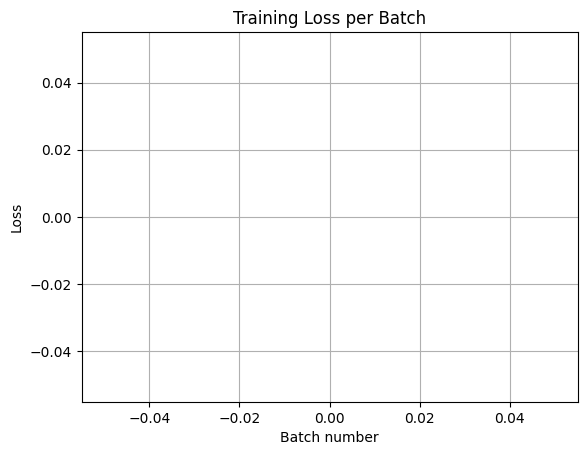

In [34]:
# Plot the loss
plt.plot(loss_values)
plt.title('Training Loss per Batch')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.grid(True)
plt.show()